### Sequential Learning for Multi-Channel Wireless Network Monitoring With Channel Switching Costs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import numpy as np
from math import pi
import itertools
import random

In [2]:
glob_range = 300
channels = 3


class AP:
    count = 0
    
    def __init__(self, x, y, channel):
        AP.count += 1
        self.x = x
        self.y = y
        self.channel = channel
        self.radius = 86

    def __str__(self):
        return "AP at (" + str(self.x) + ", " + str(self.y) + ") and channel " + str(self.channel)
        
    def in_hexagon(self, x, y):
        x = abs(x - self.x)
        y = abs(y - self.y)
        s = self.radius
        return y < 3**0.5 * min(s - x, s / 2)
    
    def sign(self,p1,p2,p3):
        return (p1.x - p3.x) * (p2.y - p3.y) - (p2.x - p3.x) * (p1.y - p3.y)
    
    def in_triangle(self, x, y):
        d1 = sign(pt, v1, v2);
        d2 = sign(pt, v2, v3);
        d3 = sign(pt, v3, v1)

        has_neg = (d1 < 0) || (d2 < 0) || (d3 < 0)
        has_pos = (d1 > 0) || (d2 > 0) || (d3 > 0)

        out = !(has_neg && has_pos)
        return out
    def in_square(self, x, y):
        x = abs(x-self.x)
        y = abs(y-self.y)
        return self.radius < max(x,y)
        

class Sniffer:
    count = 0
    
    def __init__(self, x, y):
        Sniffer.count += 1
        self.x = x
        self.y = y
        self.channel = 0
        self.radius = 200
        self.assigned_user = -1
        
    def __str__(self):
        return "Sniffer at ("+ str(self.x) + ", " + str(self.y) + ") and channel " + str(self.channel)
        
    def in_range(self, x, y):
        x = abs(x - self.x)
        y = abs(y - self.y)
        r = self.radius
        return pow(x,2.0) + pow(y,2.0) <= pow(r,2.0)
    
    def in_range_users(self, users):
        range_users = []
        for user in users:
            if self.in_range(user.x, user.y):
                range_users.append(user) 
        return range_users

    def assign_channel(self, channel):
        self.channel = channel
    
    def assign_user(self, channel, users):
        inrange_users = self.in_range_users(users)
#         inrange_users = random.shuffle(inrange_users)
        if(inrange_users is not None):
            for i,user in enumerate(inrange_users):
                if user.active and user.channel == self.channel:
                    self.assigned_user = i
                    break
        else:
            self.assigned_user = -1
            
        
class User:
    count = 0
    
    def __init__(self, x, y):
        User.count += 1
        self.x = x
        self.y = y
        self.channel = 0  
        self.active = 0
        self.activity_prob = 0.3
        
    def __str__(self):
        return "User at ("+ str(self.x) + ", " + str(self.y) + ") and channel " + str(self.channel) + " and active " + str(self.active)
    
    def in_range_sniffers(self, sniffers):
        range_sniffers = []
        for snif in sniffers:
            if snif.in_range(self.x, self.y):
                range_sniffers.append(snif)
        return range_sniffers
    
    def access_point_in_range(self, aps):
        req = []
        for ap in aps:
            if ap.in_hexagon(self.x, self.y):
                self.channel = ap.channel
                break; 
                
    def change_active(self):
        if np.random.rand() <= self.activity_prob:
            self.active = 1
        else:
            self.active = 0     

In [3]:
sniffers = []
for i in range(0, glob_range, 200):
    for j in range(0, glob_range, 200):
        sniffers.append(Sniffer(i,j))

In [4]:
for snif in sniffers:
    print(snif)

Sniffer at (0, 0) and channel 0
Sniffer at (0, 200) and channel 0
Sniffer at (200, 0) and channel 0
Sniffer at (200, 200) and channel 0


In [5]:
aps = []
for i in range(0, glob_range, 86*3):
    for j in range(0, glob_range, 86*2):
        aps.append(AP(i,j,(i+j)%3))
        
for i in range(86+int(86/2), glob_range, 86*3):
    for j in range(-86, glob_range+86, 86*2):
        aps.append(AP(i,j, (i+j)%3))

In [6]:
users = []
for i in range(0, 100):
        x = np.random.uniform(low=0, high=glob_range, size=(1,))[0]
        y = np.random.uniform(low=0, high=glob_range, size=(1,))[0]
        now = User(x, y)
        now.access_point_in_range(aps)
        now.change_active()
        users.append(now)

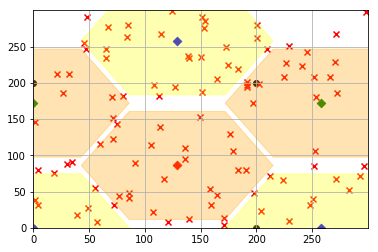

In [7]:
x = [a.x for a in sniffers]
y = [a.y for a in sniffers]

x0 = []
x1 = []
x2 = []
y0 = []
y1 = []
y2 = []

for a in aps:
    if a.channel == 0:
        x0.append(a.x)
        y0.append(a.y)
    elif a.channel == 1:
        x1.append(a.x)
        y1.append(a.y)
    else:
        x2.append(a.x)
        y2.append(a.y)        


x_u = [a.x for a in users]
y_u = [a.y for a in users]

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, glob_range, 50))
ax.set_yticks(np.arange(0, glob_range, 50))

for i, a in enumerate(aps):
    if i%2 ==0:
        circle = RegularPolygon((a.x, a.y), 6, radius=a.radius, color="yellow", orientation=pi/2, alpha=0.3)
    else:
        circle = RegularPolygon((a.x, a.y), 6, radius=a.radius, color="orange", orientation=pi/2, alpha=0.3)
    ax.add_patch(circle)
    
plt.scatter(x,y, color='black')
plt.scatter(x0,y0, color='blue', marker="D")    
plt.scatter(x1,y1, color='green', marker="D")    
plt.scatter(x2,y2, color='red', marker="D")    
plt.scatter(x_u,y_u, marker = "x", color = "red")    

ax.set_xlim(0, glob_range)
ax.set_ylim(0, glob_range)
plt.grid()
plt.show()

In [8]:
def get_iden(arr, channel, sniffer_assign):
    arr = np.array(arr)
    sniffer_assign1 = np.array(sniffer_assign)
    indices = np.where(arr > 0)[0]
    flag = 1
    for index in indices:
        if channel != sniffer_assign1[index]:
            output = 0
            flag = 0
            break
    if flag == 1:
        output = 1

    return output

def get_y(arr, channel, user_assign):
    global users
    arr = np.array(arr)
    user_assign1 = np.array(user_assign)
    indices = np.where(arr > 0)[0]
    start = user_assign1[indices[0]]
    if start == -1:
        return 0
    if channel != users[start].channel:
        return 0
    output = 1
    for index in indices[1:]:
        if start != user_assign1[index] or user_assign1[index] == -1:
            output = 0
            return output
      
    return output

In [9]:
def generate_phi(user_assign, sniffer_assign):
    n = len(sniffer_assign)
    now = ["".join(seq) for seq in itertools.product("01", repeat=n)]
    now.remove("".join([str(0) for i in range(n)]))
    phi = []
    y = []
    for a in now:
        a =  list(map(int, list(a)))
        for channel in range(0, channels):
            phi.append(get_iden(a, channel, sniffer_assign))
            y.append(get_y(a, channel, user_assign))
    phi = np.array(phi)
    y = np.array(y)
    return (phi, y)

In [10]:
spanners = []

for channel in range(0, channels):
    for snif in sniffers:
        snif.assign_channel(channel)
    user_assign = [snif.assigned_user for snif in sniffers]

    sniffer_assign = [snif.channel for snif in sniffers]
    
    spanners.append(generate_phi(user_assign, sniffer_assign)[0])

In [11]:
phis = []
k = 0

In [12]:
def gen_all_phis(n , channel_assign):
    global phis, k
    if n == 0:
        return 
    snif1 = sniffers[n-1]
    for channel in range(0, channels):
        snif1.assign_channel(channel)
        k += 1
        user_assign = [snif.assigned_user for snif in sniffers]
        sniffer_assign = [snif.channel for snif in sniffers]
        gen_all_phis(n-1, sniffer_assign.copy())
        phis.append((sniffer_assign, generate_phi(user_assign, sniffer_assign)[0]))
        phis.append((sniffer_assign , generate_phi(user_assign, sniffer_assign)[0]))
    return phis

In [13]:
class ucb_agent():  
    def __init__(self,k,alpha,sniffers,spanners):
        self.arm_count = k #spanner size
        self.alpha = alpha #param
        self.N = np.ones(((2**sniffers-1)*k))
        self.trials = 1
        self.V = np.zeros((k,))
        self.mean = np.zeros((k,))
        self.theta = np.zeros(((2**sniffers-1)*k))
        self.spanners=spanners
        self.reward = [1]
        self.reward_avg = [1]
        self.arm = []
        self.switching_regret = [0]
        self.s_cost = 2

        
    def get_action(self):
        self.trials += 1
        out = np.argmax(self.V)
        
        self.reward_avg.append((self.mean[out]+(self.trials-1)*self.reward[-1])/self.trials)
        self.reward.append(self.mean[out])
        self.arm.append(out)
        try:
            if out != self.arm[-2]:
                self.switching_regret.append(self.switching_regret[-1]+self.s_cost)
            else:
                self.switching_regret.append(self.switching_regret[-1])
        except:
            pass
        return out
    
    def update_theta(self,Y,phi):
        self.theta = self.theta + (Y-self.theta)*phi/self.N
        self.N = self.N + np.absolute(phi)
        
    def update(self,Y,phi):
        scale = (self.alpha*np.log(self.trials))**0.5
        for i in range(self.arm_count):
            self.V[i] = self.mean[i] + (scale)*np.sum(((1/self.N)**0.5)*self.spanners[i])
            self.mean[i] = np.dot(self.theta,self.spanners[i])
        return 
    

In [14]:
def get_regret(agent,spanners):
    optimal_index = np.argmax(agent.reward[1500:])+1500
    optimal = agent.arm[optimal_index-1]
    optimal_phi = spanners[optimal]
    reg = [0]
    for i in range(len(agent.arm)):
        reg.append(reg[-1]+(np.dot(optimal_phi,agent.theta)-np.dot(spanners[agent.arm[i]],agent.theta)))
    return reg 

In [15]:
import tqdm
regret = []
s_regret = []
for trials in tqdm.tqdm(range(10)):
    spanners = []
    for channel in range(0, channels):
        for snif in sniffers:
            snif.assign_channel(channel)
        user_assign = [snif.assigned_user for snif in sniffers]
        sniffer_assign = [snif.channel for snif in sniffers]    
        spanners.append(generate_phi(user_assign, sniffer_assign)[0])


    agent = ucb_agent(k = channels, alpha=0.1, sniffers=len(sniffers), spanners=spanners)


    for action in range(channels):
        for i in users:
            i.change_active()
        for j in sniffers:
            j.assign_channel(action)
            j.assign_user(1,users)

        user_assign = [snif.assigned_user for snif in sniffers]
        sniffer_assign = [snif.channel for snif in sniffers]

        phi, Y = generate_phi(user_assign, sniffer_assign)
        agent.update(Y,phi)
        agent.update_theta(Y,phi)


    epoch_len =1
    epoch_counter = np.ones((2**len(sniffers) - 1)*channels)
    steps = 10000
    alpha = 1
    for t in range(steps):
        epoch_len -= 1
        for i in users:
            i.change_active()
        action = agent.get_action()
        for j in sniffers:
            j.assign_channel(action)
            j.assign_user(1,users)


        user_assign = [snif.assigned_user for snif in sniffers]
        sniffer_assign = [snif.channel for snif in sniffers]

        phi, Y = generate_phi(user_assign, sniffer_assign)
        if epoch_len<0:
            epoch_counter += np.absolute(phi)
            control = np.argmin(agent.N)
            epoch_len = (1+alpha)**(epoch_counter[control]) - (1+alpha)**(epoch_counter[control]-1)
            agent.update(Y,phi)
        agent.update_theta(Y,phi)
    s_regret.append(agent.switching_regret)
    regret.append(get_regret(agent=agent,spanners=spanners))
    
    

avg_regret = np.array(regret).mean(axis=0)
# plt.plot(avg_regret)

avg_s_regret = np.array(s_regret).mean(axis=0)
# plt.plot(avg_s_regret)

avg_tot_regret = avg_s_regret + avg_regret[:len(avg_s_regret)]
# plt.plot(avg_tot_regret)

100%|██████████| 10/10 [01:26<00:00,  8.66s/it]


In [16]:
import tqdm
regret = []
s_regret = []
for trials in tqdm.tqdm(range(10)):
    spanners = []
    for channel in range(0, channels):
        for snif in sniffers:
            snif.assign_channel(channel)
        user_assign = [snif.assigned_user for snif in sniffers]
        sniffer_assign = [snif.channel for snif in sniffers]    
        spanners.append(generate_phi(user_assign, sniffer_assign)[0])


    agent = ucb_agent(k = channels, alpha=0.1, sniffers=len(sniffers), spanners=spanners)

    epoch_len =1
    epoch_counter = np.ones((2**len(sniffers) - 1)*channels)
    steps = 10000
    alpha = 1
    for t in range(steps):
        epoch_len -= 1
        for i in users:
            i.change_active()
        action = agent.get_action()
        for j in sniffers:
            j.assign_channel(action)
            j.assign_user(1,users)


        user_assign = [snif.assigned_user for snif in sniffers]
        sniffer_assign = [snif.channel for snif in sniffers]

        phi, Y = generate_phi(user_assign, sniffer_assign)
        agent.update(Y,phi)
        agent.update_theta(Y,phi)
    s_regret.append(agent.switching_regret)
    regret.append(get_regret(agent=agent,spanners=spanners))

avg_regret_naive = np.array(regret).mean(axis=0)
# plt.plot(avg_regret_naive)

avg_s_regret_naive = np.array(s_regret).mean(axis=0)
# plt.plot(avg_s_regret_naive)

avg_tot_regret_naive = avg_s_regret_naive + avg_regret_naive[:len(avg_s_regret_naive)]
# plt.plot(avg_tot_regret_naive)

100%|██████████| 10/10 [01:29<00:00,  8.92s/it]


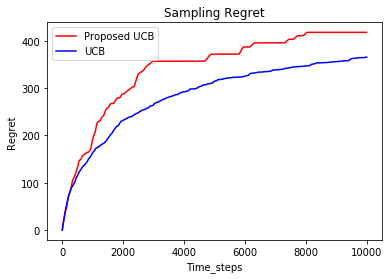

<Figure size 432x288 with 0 Axes>

In [17]:
x = list(range(10000))
plt.plot(x,avg_regret[:10000],c = "r",label="Proposed UCB")
plt.plot(x,avg_regret_naive[:10000],c = "b",label="UCB")
plt.xlabel("Time_steps")
plt.ylabel("Regret")
plt.title("Sampling Regret")
plt.legend()
plt.show()
plt.savefig("sampling_regret.png")

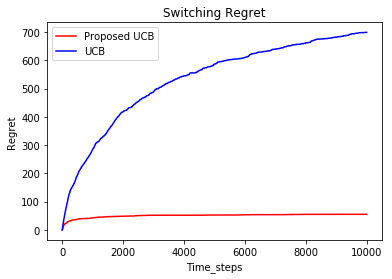

<Figure size 432x288 with 0 Axes>

In [18]:
x = list(range(10000))
plt.plot(x,avg_s_regret[:10000],c = "r",label = "Proposed UCB")
plt.plot(x,avg_s_regret_naive[:10000],c = "b",label = "UCB")
plt.xlabel("Time_steps")
plt.ylabel("Regret")
plt.title("Switching Regret")
plt.legend()
plt.show()
plt.savefig("switching_regret.png")

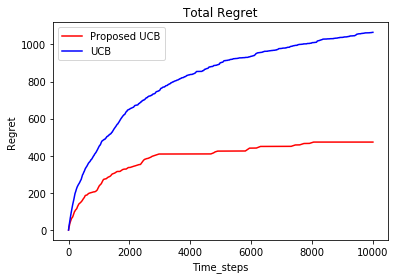

<Figure size 432x288 with 0 Axes>

In [19]:
x = list(range(10000))
plt.plot(x,avg_tot_regret[:10000],c = "r",label = "Proposed UCB")
plt.plot(x,avg_tot_regret_naive[:10000],c = "b",label = "UCB")
plt.xlabel("Time_steps")
plt.ylabel("Regret")
plt.title("Total Regret")
plt.legend()
plt.show()
plt.savefig("total_regret.png")